# CA3 - Data Driven Model
- Student Name: **Vinicius Moura Barros**
- Student Number: **T00244396**
## **Allocation of marks**

Stages 1,2,3   Total 30%

Ideally your dataset will not need a lot of work. Marks going for the choosing,  training, evaluation and refining of model primarily


---



Stage 4,5       Total 60%

Choose your model

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


Train and evaluate your model. Refine the model or choose another estimator or approach?

Do not overwrite cells and add commentry between iterations.



---




Stage 6         Total 10%

## **Stage 0**
### Preparation of Environment
This section outlines what needs to be installed on the Python environment before this notebook can be executed.
Python3 is being used for this project. The following packages need to be installed (e.g.: via `pip install`):
- scikit-learn
- pandas
- graphviz (might require additional steps to be installed, see [graphviz website](https://graphviz.org/download/))


 ### Importing the libraries

In [51]:
import pandas as pd
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
import graphviz


# **Stage 1**

### Background
Overwatch is a team-based multiplayer first-person shooter developed and published by Blizzard Entertainment. Overwatch League is the official professional and competitive Overwatch league, where teams compete against each other through the year.

A regular official match is composed of a multiple games (or maps), whereas the first team to have 3 games (maps) won, wins the match. Each game is played in a different map, and each map has its own characteristics, which can be advantageous or disadvantageous to a team, depending on their playstyle.

The team who loses a map has the chance of choosing what next map they want to play. And this is exactly the type of question that this notebook will try to answer: given a team and this team's adversary, what map should they choose next, in order to increase their chances of winning the match?

### Describe Data

The dataset chosen for this notebook was a list of previous matches from Overwatch League.
All Overwatch League public available datasets can be found in [Overwatch League official statslab](https://overwatchleague.com/en-us/statslab), and the one used for this notebook can be downloaded exactly from [this URL](https://assets.blz-contentstack.com/v3/assets/blt321317473c90505c/blta8c8b99af29af2be/63f51f804f98c853eaf0983b/match_map_stats.csv.zip).

The dataset contains almost 14.000 rows with data about official matches that happened between 11/2018 and 05/2022.


### Loading Dataset
As the dataset may not be available during the execution of this notebook, a copy can be found in ./data/overwatch_match_map_stats.csv. By loading it from a local disk, it will also make the loading process faster.

In [52]:
DATASET = 'data/overwatch_match_map_stats.csv'
df = pd.read_csv(DATASET)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13901 entries, 0 to 13900
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   round_start_time              13901 non-null  object 
 1   round_end_time                13901 non-null  object 
 2   stage                         13901 non-null  object 
 3   match_id                      13901 non-null  int64  
 4   game_number                   13901 non-null  int64  
 5   match_winner                  13901 non-null  object 
 6   map_winner                    13901 non-null  object 
 7   map_loser                     13901 non-null  object 
 8   map_name                      13901 non-null  object 
 9   map_round                     13901 non-null  int64  
 10  winning_team_final_map_score  13901 non-null  int64  
 11  losing_team_final_map_score   13901 non-null  int64  
 12  control_round_name            4270 non-null   object 
 13  A

In [53]:
df.head()

round_start_time  round_end_time          stage  match_id  game_number  \
0   01/11/18 00:12  01/11/18 00:20  2018: Stage 1     10223            1   
1   01/11/18 00:22  01/11/18 00:27  2018: Stage 1     10223            1   
2   01/11/18 00:34  01/11/18 00:38  2018: Stage 1     10223            2   
3   01/11/18 00:40  01/11/18 00:44  2018: Stage 1     10223            2   
4   01/11/18 00:46  01/11/18 00:49  2018: Stage 1     10223            2   

          match_winner           map_winner            map_loser  \
0  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
1  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
2  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
3  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
4  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   

           map_name  map_round  ...        team_one_name        team_two_name  \
0            Dorado          1  ...  Los Angeles Valiant  San Francisco Shock   
1            Dorado          2  ...  Los Angeles Valiant  San Francisco Shock   
2  Temple of Anubis          1  ...  Los Angeles Valiant  San Francisco Shock   
3  Temple of Anubis          2  ...  Los Angeles Valiant  San Francisco Shock   
4  Temple of Anubis          3  ...  Los Angeles Valiant  San Francisco Shock   

  attacker_payload_distance defender_payload_distance attacker_time_banked  \
0                  75.61505                   0.00000             0.000000   
1                  75.64960                  75.61505           125.750570   
2                   0.00000                   0.00000           250.492000   
3                   0.00000                   0.00000           225.789030   
4                   0.00000                   0.00000            36.396057   

  defender_time_banked attacker_control_perecent  defender_control_perecent  \
0              240.000                       NaN                        NaN   
1                0.000                       NaN                        NaN   
2              240.000                       NaN                        NaN   
3              250.492                       NaN                        NaN   
4              250.492                       NaN                        NaN   

   attacker_round_end_score  defender_round_end_score  
0                         2                         0  
1                         3                         2  
2                         2                         0  
3                         2                         2  
4                         4                         2  

[5 rows x 25 columns]

# **Stage 2**

### Justification for the property that you would like the model to predict.

As described in the Background section, during a match, the team that lost a game (or map) have the chance of choosing the next map to be played. By analyzing historical data, the team might could take advantage of that to maximize their chances of winning the next map (and eventually the match).

This is exactl question that this notebook will try to answer: **given a team and this team’s adversary, what map should they choose next, in order to increase their chances of winning the match?**

Based on team_one_name, team_two_name, map_name and map_winner, we will try to predict what map should the team choose next.



# **Stage 3**

### Cleaning the data, linking datasets etc..



As the main objective is to predict what map to chose, we don't need all the data present in the dataset, so we will filter it to have only the data necessary to train the model.


In [54]:
df = df[['team_one_name', 'team_two_name', 'map_name', 'map_winner']]

In [55]:
df.head()

team_one_name        team_two_name          map_name  \
0  Los Angeles Valiant  San Francisco Shock            Dorado   
1  Los Angeles Valiant  San Francisco Shock            Dorado   
2  Los Angeles Valiant  San Francisco Shock  Temple of Anubis   
3  Los Angeles Valiant  San Francisco Shock  Temple of Anubis   
4  Los Angeles Valiant  San Francisco Shock  Temple of Anubis   

            map_winner  
0  Los Angeles Valiant  
1  Los Angeles Valiant  
2  Los Angeles Valiant  
3  Los Angeles Valiant  
4  Los Angeles Valiant

Also, as the data present in the dataset are mainly strings for team names and map names, we need to convert them to numerical data, so the model can understand it. For this, we will use the LabelEncoder from scikit-learn.

The helper functions below will help us to convert the data to numerical data and also to convert it back to the original data whenever needed.

In [56]:
default_dict = defaultdict(LabelEncoder)

# we need to convert the categorical data into numerical data so the model can understand it
def categorize_df(df: pd.DataFrame):
    return df.apply(lambda x: default_dict[x.name].fit_transform(x))


def prettify_df(categorized_df: pd.DataFrame):
    return categorized_df.apply(lambda x: default_dict[x.name].inverse_transform(x))


# **Stage 4**
### Choose and train Estimator.

To help finding an estimator, the [Scikit-Learn Choosing the Right Estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) was used as a guide:
- We have more than 50 samples
- We are trying to predict a category
- We have labeled data

So we land in the Classification category.

The initial estimator chosen for this notebook is the Decision Tree Classifier, however we want to experiment with other classification methods, such as like LogisticRegression and see if one is more accurate than the other.

In [57]:
# These are the features to be taken into consideration when training the model
features = ['team_one_name', 'team_two_name', 'map_name']

# And target is what we want to be able to predict
target = 'map_winner'

random_state = 42
# percentage of the dataset to be used for testing (the remainder will be used for training)
test_size = 0.5

categorized_df = categorize_df(df)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(categorized_df[features], categorized_df[target],
                                                    test_size=test_size, random_state=random_state)

print(len(X_train), len(X_test), len(y_train), len(y_test))



6950 6951 6950 6951


#### DecisionTreeClassifier
Let's create an estimator with the Decision Tree Classifier

In [58]:
# create a decision tree classifier
estimator = DecisionTreeClassifier()

# fit the model on the training data
estimator.fit(X_train, y_train)

# make predictions on the testing data
y_pred = estimator.predict(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7220543806646526


By using the DecisionTreeClassifier, we got an accuracy of more than 72% for the test (not used in the training) data, which is already impressive.

# **Stage 5**
### Evaluate your model and revisit 4...repeat..
Now that we have a base-line for comparison (72% of accuracy), let's experiment other estimators and see if we can get a better accuracy with other known classification models, using the same test/train conditions.

In [59]:
estimators_to_be_tested = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SGDClassifier': SGDClassifier(),
    'SVC': SVC(max_iter=10000),
}

for name, estimator_instance in estimators_to_be_tested.items():
    estimator_instance.fit(X_train, y_train)
    temp_y_pred = estimator_instance.predict(X_test)
    accuracy = accuracy_score(y_test, temp_y_pred)
    print(f"Accuracy for {name}: {accuracy}")

Accuracy for LogisticRegression: 0.12041432887354338
Accuracy for RandomForestClassifier: 0.7132786649402963
Accuracy for KNeighborsClassifier: 0.5110056107034959
Accuracy for SGDClassifier: 0.07869371313480075
Accuracy for SVC: 0.29247590274780605


As we can observe on the results above, given the exact same training/test data, the Decision Tree has still better results than the other ones. So, for now, we will keep using the Decision Tree Classifier.

### Fine-tuning
Now that we have decided to continue using the Decision Tree Classifier, let's try to fine-tune it to see if we can get a better accuracy.
We'll loop through possible percentages of test_sizes (from 1% until 100%) and see if we can get a better accuracy without overfitting the model.

<AxesSubplot:title={'center':'Accuracy by size of trained data'}, xlabel='% of dataset for training', ylabel='Accuracy %'>

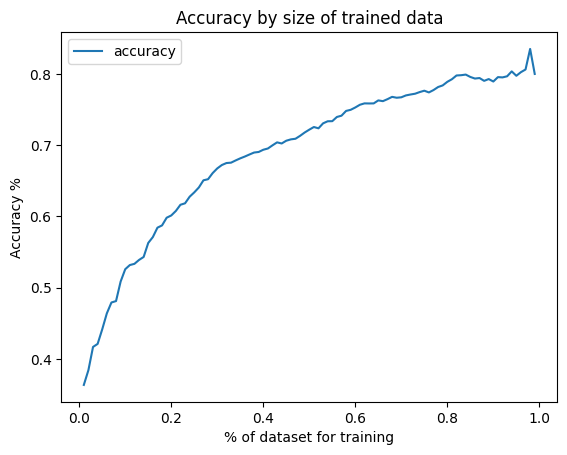

In [60]:
# These are the features to be taken into consideration when training the model
features = ['team_one_name', 'team_two_name', 'map_name']

# And target is what we want to be able to predict
target = 'map_winner'

random_state = 42

# percentage of the dataset to be used for testing (the remainder will be used for training)
test_sizes = range(1, 100)

results = {'test_size': [], 'train_size':[], 'accuracy': []}

for size in test_sizes:
    size = size/100
    categorized_df = categorize_df(df)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(categorized_df[features], categorized_df[target],
                                                        test_size=size, random_state=random_state)

    # create a decision tree classifier
    estimator = DecisionTreeClassifier()

    # fit the model on the training data
    estimator.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = estimator.predict(X_test)

    # evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # store the results
    results['test_size'].append(size)
    results['train_size'].append(1-size)
    results['accuracy'].append(accuracy)


# let's plot the results
results_df = pd.DataFrame(results)
results_df.plot(x='train_size', y='accuracy', title='Accuracy by size of trained data', kind='line', xlabel='% of dataset for training', ylabel='Accuracy %')

In [61]:
results_df

test_size  train_size  accuracy
0        0.01        0.99  0.800000
1        0.02        0.98  0.835125
2        0.03        0.97  0.806220
3        0.04        0.96  0.802513
4        0.05        0.95  0.797414
..        ...         ...       ...
94       0.95        0.05  0.441466
95       0.96        0.04  0.420982
96       0.97        0.03  0.416716
97       0.98        0.02  0.384203
98       0.99        0.01  0.363392

[99 rows x 3 columns]

As we can observe in the Line diagram and in the table above, the accuracy of the model is affected depending on the size of the dataset used for training. The model has an accuracy of 79% using 81% of the dataset for training. 81% is the percentages that will be utilized for training our model, as it provide a good enough accuracy without causing overfitting.

So we'll change from 50% to 81% the size of the dataset used for training, with an improvement of 7% in accuracy.

So let's train our model again (next cell), but this time using 81% of the dataset for training.



In [62]:
# These are the features to be taken into consideration when training the model
features = ['team_one_name', 'team_two_name', 'map_name']

# And target is what we want to be able to predict
target = 'map_winner'

random_state = 42

# percentage of the dataset to be used for testing (the remainder will be used for training)
test_size = 0.19  # (81% used for training)

categorized_df = categorize_df(df)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(categorized_df[features], categorized_df[target],
                                                    test_size=test_size, random_state=random_state)
# create a decision tree classifier
estimator = DecisionTreeClassifier()

# fit the model on the training data
estimator.fit(X_train, y_train)

# make predictions on the testing data
y_pred = estimator.predict(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.7922028766086299


### Visualizing the model
Using Graphviz we can visualize how the model looks like.
As the visualization is not clear enough in the notebook, please refer to the file `decision_tree_diagram_for_overwatch_map.pdf` in the same directory as the notebook.

In [63]:
data = export_graphviz(estimator, out_file=None, feature_names=list(X_train.columns.values), filled=True, rounded=True)
graph = graphviz.Source(data)
graph.render('decision_tree_diagram_for_overwatch_map', view=False, overwrite_source=True, cleanup=True)

'decision_tree_diagram_for_overwatch_map.pdf'

In [64]:
graph

### Randomly testing
Let's randomly pick 10 rows from the dataset and see if the model can predict the winner of the map correctly.

In [65]:
random_to_check = [random.randint(0, len(df)) for _ in range(10)]

to_test = categorized_df.loc[random_to_check]

to_test['prediction'] = estimator.predict(to_test[features])

# check the last 2 columns to compare map_winner and prediction
print(to_test[['team_one_name', 'team_two_name', 'map_winner', 'prediction']])

       team_one_name  team_two_name  map_winner  prediction
8432              11              5          11          11
3231              10             13          13          13
11755              3              9           3           3
4873               7              4           7           7
2112               1             10          10          10
359                4             10           4           4
12157             18             20          20          20
6217              14             11          14          14
2644              11             13          13          11
5740               4              1           4           4


## Stage 5.5 Tool for teams
Despite not being explicitly requested, at this stage, we'll provide a tool for teams to be able to use the model to predict what map to choose next.
Users of this tool will be asked 2 inputs: ID of their team and ID of the opponent team.

Then the tool will take all existing maps and based on the user inputs will try to predict the winner (if any) of each map.
This is essentially the final goal of the project, so we'll be using the model we trained and refined from the previous stages.

In [66]:
print("List of Teams Available")
teams = df['team_one_name'].unique()
for i, name in enumerate(teams):
    print(f"{i} - {name}")

List of Teams Available
0 - Los Angeles Valiant
1 - Los Angeles Gladiators
2 - Shanghai Dragons
3 - Seoul Dynasty
4 - Dallas Fuel
5 - Florida Mayhem
6 - London Spitfire
7 - Houston Outlaws
8 - Philadelphia Fusion
9 - New York Excelsior
10 - Boston Uprising
11 - San Francisco Shock
12 - Hangzhou Spark
13 - Toronto Defiant
14 - Atlanta Reign
15 - Chengdu Hunters
16 - Guangzhou Charge
17 - Paris Eternal
18 - Washington Justice
19 - Vancouver Titans
20 - Vegas Eternal
21 - Seoul Infernal


### Choosing teams
Here we'll ask users to input their team and their opponent team.


In [67]:
my_team, opponent_team = None, None

while my_team is None:
    team = int(input(f"What is your team? (0-{len(teams)-1})"))
    if 0 <= team < len(teams):
        print(f"Your team is {teams[team]}")
        my_team = team
    else:
        print("Invalid choice, please try again")

while opponent_team is None:
    team = int(input(f"What is your opponent team?(0-{len(teams)-1}) It must not be {teams[my_team]} "))
    if 0 <= team < len(teams):
        print(f"Your opponent team is {teams[team]}")
        opponent_team = team
    else:
        print("Invalid choice, please try again")

Your team is Florida Mayhem
Your opponent team is London Spitfire


### Computing Predictions
Here we'll compute the predictions for each map, and we'll show the results to the user.

In [68]:
unique_maps = list(df['map_name'].unique())

# Let's build a dict w/ all unique maps and our team (as team one) and the opponent team (as team two)
dict_data = {
    'map_name': unique_maps,
    'team_one_name': [teams[my_team]] * len(unique_maps),
    'team_two_name': [teams[opponent_team]] * len(unique_maps)
}

# Let's make a copy of the original DF
temp_df = df.copy(deep=True)

# Let's append the data we want to predict
temp_df = temp_df.append(pd.DataFrame(dict_data), ignore_index=True)

# Let's categorize the data, so we can use it to predict
temp_df = categorize_df(temp_df)

# Let's create a new DF only w/ the data to be predicted (but still categorized)
prediction_only_df = temp_df.tail(len(unique_maps))

# calculate the prediction for each map
prediction_winner = estimator.predict(prediction_only_df[features])

prediction_only_df = prettify_df(prediction_only_df)
prediction_only_df['prediction_winner'] = prediction_winner
prediction_only_df['prediction_winner'] = default_dict['map_winner'].inverse_transform(prediction_only_df['prediction_winner'])
final_prediction_df = prediction_only_df[features+['prediction_winner']].reset_index()
display(final_prediction_df)


index   team_one_name    team_two_name               map_name  \
0   13901  Florida Mayhem  London Spitfire                 Dorado   
1   13902  Florida Mayhem  London Spitfire       Temple of Anubis   
2   13903  Florida Mayhem  London Spitfire                  Ilios   
3   13904  Florida Mayhem  London Spitfire                Numbani   
4   13905  Florida Mayhem  London Spitfire            Eichenwalde   
5   13906  Florida Mayhem  London Spitfire             Junkertown   
6   13907  Florida Mayhem  London Spitfire                  Oasis   
7   13908  Florida Mayhem  London Spitfire   Horizon Lunar Colony   
8   13909  Florida Mayhem  London Spitfire          Lijiang Tower   
9   13910  Florida Mayhem  London Spitfire    Volskaya Industries   
10  13911  Florida Mayhem  London Spitfire                  Nepal   
11  13912  Florida Mayhem  London Spitfire             King's Row   
12  13913  Florida Mayhem  London Spitfire               Route 66   
13  13914  Florida Mayhem  London Spitfire              Hollywood   
14  13915  Florida Mayhem  London Spitfire               Hanamura   
15  13916  Florida Mayhem  London Spitfire  Watchpoint: Gibraltar   
16  13917  Florida Mayhem  London Spitfire         Blizzard World   
17  13918  Florida Mayhem  London Spitfire                 Rialto   
18  13919  Florida Mayhem  London Spitfire                  Busan   
19  13920  Florida Mayhem  London Spitfire                  Paris   
20  13921  Florida Mayhem  London Spitfire                 Havana   
21  13922  Florida Mayhem  London Spitfire                Midtown   
22  13923  Florida Mayhem  London Spitfire          Circuit royal   
23  13924  Florida Mayhem  London Spitfire       New Queen Street   
24  13925  Florida Mayhem  London Spitfire               Colosseo   
25  13926  Florida Mayhem  London Spitfire                Paraíso   
26  13927  Florida Mayhem  London Spitfire              Esperança   

   prediction_winner  
0     Florida Mayhem  
1    London Spitfire  
2     Florida Mayhem  
3    London Spitfire  
4     Florida Mayhem  
5     Florida Mayhem  
6    London Spitfire  
7     Florida Mayhem  
8    London Spitfire  
9               draw  
10   London Spitfire  
11   London Spitfire  
12   London Spitfire  
13    Florida Mayhem  
14    Florida Mayhem  
15    Florida Mayhem  
16    Florida Mayhem  
17    Florida Mayhem  
18    Florida Mayhem  
19    Florida Mayhem  
20    Florida Mayhem  
21   London Spitfire  
22    Florida Mayhem  
23   London Spitfire  
24    Florida Mayhem  
25   London Spitfire  
26    Florida Mayhem

# **Stage 6**
### Present results and Conclusions

The original goal of this project was trying to answer whether given a Team One and Team Two, we could predict which maps should a team choose to play against another team with higher changes of winning.

Being guided by existing suggested strategies (from scikit) we could choose why type of models we wanted to use to solve this problem. We used Classification models and compared a few of them, with the most suitable one for this case (under the investigated scenarios) being the Decision Tree Classifier.

Without overfitting the model, we could achieve an accuracy of 79%, which required 81% of the dataset to be used for the model training.

It is important to highlight that despite the accuracy mentioned in this study, teams change overtime and the meta of the game (internal balancing of characters or rules of Overwatch) also changes multiple times over the year, so the model might not be as accurate for future predictions.

In the end, a tool was also developed to allow users to input their team and their opponent team, and it would predict which team would win (or draw) a game in each of the maps available. The prediction was done using the trained and refined model with 79% of accuracy.





